# Bayesian Machine Learning Assignment 1

Cassandra Maldonado

In [28]:
import probml_utils.pgmpy_utils as pgm
from causalgraphicalmodels import CausalGraphicalModel
# Note: If you are using python 3.3 or greater, you will need to update collections to collections.abc
import pgmpy
import numpy as np
import pandas as pd
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination

1. Download the simulated dataset “diabetes_data.csv”. This dataset involves records of 10,000 simulated patients who answered some questions about their lifestyle and went through some medical tests.

In [29]:
import pandas as pd
import numpy as np

In [30]:
data = pd.read_csv('diabetes_data-1.csv')
data.drop('Unnamed: 0', axis=1, inplace=True)

a) Build this model in the figure and learn the conditional probability tables for this model (from data).

In [5]:
pip install pgmpy

Note: you may need to restart the kernel to use updated packages.


In [31]:
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD 
from pgmpy.inference import VariableElimination

In [46]:
def draw_model(model, title):
    net = BayesianNetwork(model.edges())
    
    dot = pgm.visualize_model(net)
    dot.attr(label=title, labelloc="top") 
    display(dot)


In [47]:
def calculate_cpts(model, data):
    net = BayesianNetwork(model.edges())
    mle = MaximumLikelihoodEstimator(net, data)
    for cpd in mle.get_parameters():
        net.add_cpds(cpd)
    if not net.check_model():
        raise ValueError("The model is invalid. Check the structure and data.")
    for cpd in net.get_cpds():
        print(f"CPD of {cpd.variable}:\n{cpd}\n")
    dot = pgm.visualize_model(net)
    display(dot)
    return net


In [49]:
from pgmpy.estimators import MaximumLikelihoodEstimator

net = BayesianNetwork([('BMI', 'diabetes'), ('sugar', 'diabetes')])
mle = MaximumLikelihoodEstimator(model, data)

for cpd in mle.get_parameters():
    net.add_cpds(cpd)

net.check_model()

True

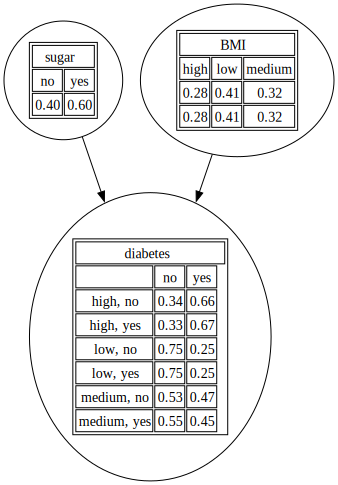

In [50]:
dot = pgm.visualize_model(net)
display(dot)

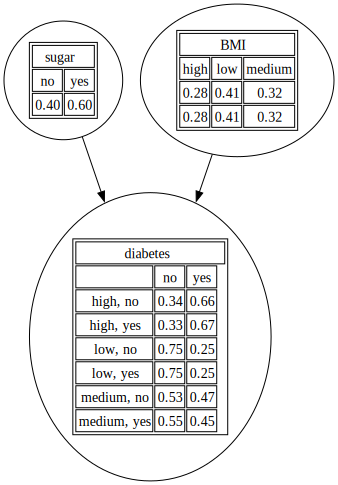

In [51]:
dot = pgm.visualize_model(net)
display(dot)

In [52]:
cpd_diabetes = data.groupby(["sugar", "BMI"])["diabetes"].value_counts(normalize=True).unstack()

print(cpd_diabetes)

diabetes            no       yes
sugar BMI                       
no    high    0.343750  0.656250
      low     0.753225  0.246775
      medium  0.533989  0.466011
yes   high    0.329067  0.670933
      low     0.748804  0.251196
      medium  0.553886  0.446114


In [53]:
from pgmpy.factors.discrete import TabularCPD

diabetes_values = cpd_diabetes.values.T.tolist()

# CPD for diabetes
cpd_diabetes = TabularCPD(
    variable="diabetes",
    variable_card=2,  # Two possible values: yes (1) and no (0)
    values=diabetes_values,
    evidence=["sugar", "BMI"],
    evidence_card=[2, 3],  # Sugar (yes/no), BMI (low/medium/high)
    state_names={"diabetes": ["no", "yes"], "sugar": ["no", "yes"], "BMI": ["low", "medium", "high"]}
)

In [54]:
cpd_sugar = TabularCPD(
    variable="sugar",
    variable_card=2,
    values=[[0.4], [0.6]],  # Example: 40% of people have low sugar, 60% have high sugar
    state_names={"sugar": ["no", "yes"]}
)

In [55]:
cpd_BMI = TabularCPD(
    variable="BMI",
    variable_card=3,
    values=[[0.3], [0.5], [0.2]],  # Example: 30% low, 50% medium, 20% high BMI
    state_names={"BMI": ["low", "medium", "high"]}
)

In [56]:
model.add_cpds(cpd_sugar, cpd_BMI, cpd_diabetes)

assert model.check_model(), "Model structure is invalid!"
print("Model structure is valid")

Model structure is valid


b) Given a patient is diagnosed with diabetes, what’s the probability that their daily sugar intake is high.

In [57]:
inference = VariableElimination(model)

# Probability of high sugar intake given diabetes
result = inference.query(variables=["sugar"], evidence={"diabetes": "yes"})

print(result)

+------------+--------------+
| sugar      |   phi(sugar) |
+============+==============+
| sugar(no)  |       0.3985 |
+------------+--------------+
| sugar(yes) |       0.6015 |
+------------+--------------+


The probability of a patient having diabetes given that their daily sugar intake is high > 7 is 60.15%.

2a) Split the data into 80% training and 20% validation sets.

In [58]:
from sklearn.model_selection import train_test_split

# Converting categorical variables to string
data = data.astype(str)

# Splitting into 80% training, 20% validation.
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

print("Training data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)

Training data shape: (8000, 6)
Validation data shape: (2000, 6)


2b) Using each of these structure learning methodologies, search for a better model using the training data. Draw these new models’ Bayes Nets (nodes and edges). Calculate the conditional probability tables for these new models.

  0%|          | 0/5 [00:00<?, ?it/s]

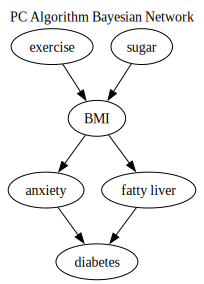

CPD of anxiety:
+---------------+-----+---------------------+
| BMI           | ... | BMI(medium)         |
+---------------+-----+---------------------+
| anxiety(high) | ... | 0.6077568972411036  |
+---------------+-----+---------------------+
| anxiety(low)  | ... | 0.39224310275889646 |
+---------------+-----+---------------------+

CPD of diabetes:
+---------------+-----+---------------------+
| anxiety       | ... | anxiety(low)        |
+---------------+-----+---------------------+
| fatty liver   | ... | fatty liver(low)    |
+---------------+-----+---------------------+
| diabetes(no)  | ... | 0.9044269755895739  |
+---------------+-----+---------------------+
| diabetes(yes) | ... | 0.09557302441042614 |
+---------------+-----+---------------------+

CPD of exercise:
+------------------+---------+
| exercise(high)   | 0.2005  |
+------------------+---------+
| exercise(low)    | 0.29125 |
+------------------+---------+
| exercise(medium) | 0.50825 |
+------------------+------

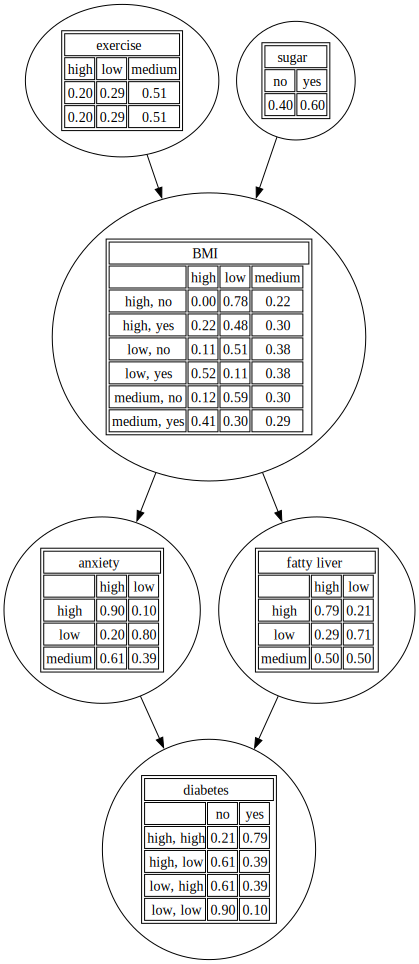

In [59]:
from pgmpy.estimators import PC, HillClimbSearch, TreeSearch
from pgmpy.models import BayesianNetwork

# PC Algorithm
pc = PC(train_data)
pc_model = pc.estimate(return_type="dag")

draw_model(pc_model, "PC Algorithm Bayesian Network")
pc_model = calculate_cpts(pc_model, train_data)

  0%|          | 0/1000000 [00:00<?, ?it/s]

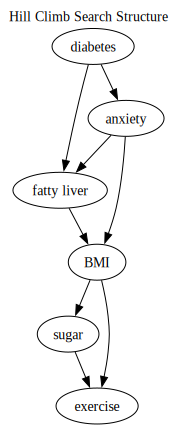

CPD of BMI:
+-------------+---------------------+-----+---------------------+
| anxiety     | anxiety(high)       | ... | anxiety(low)        |
+-------------+---------------------+-----+---------------------+
| fatty liver | fatty liver(high)   | ... | fatty liver(low)    |
+-------------+---------------------+-----+---------------------+
| BMI(high)   | 0.6176125244618396  | ... | 0.02027306578402979 |
+-------------+---------------------+-----+---------------------+
| BMI(low)    | 0.07906066536203522 | ... | 0.7707902358295408  |
+-------------+---------------------+-----+---------------------+
| BMI(medium) | 0.30332681017612523 | ... | 0.20893669838642945 |
+-------------+---------------------+-----+---------------------+

CPD of sugar:
+------------+---------------------+---------------------+--------------------+
| BMI        | BMI(high)           | BMI(low)            | BMI(medium)        |
+------------+---------------------+---------------------+--------------------+
| sugar

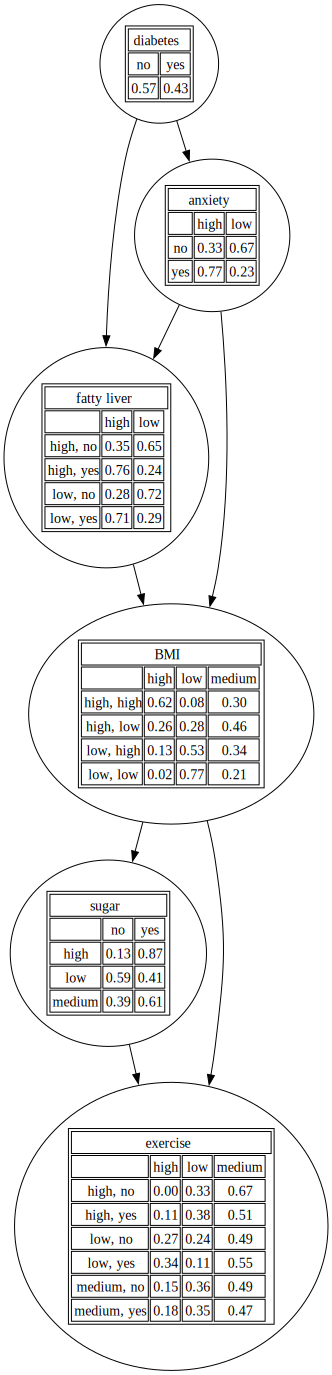

In [60]:
from pgmpy.estimators import K2Score

# Hill Climb Search with K2 score
hc = HillClimbSearch(train_data)
hc_model = hc.estimate(scoring_method=K2Score(train_data))

draw_model(hc_model, "Hill Climb Search Structure")
hc_model = calculate_cpts(hc_model, train_data)

Building tree:   0%|          | 0/15.0 [00:00<?, ?it/s]

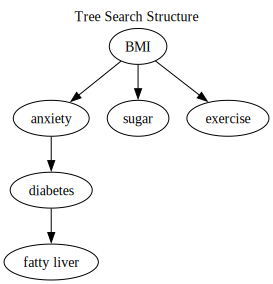

CPD of BMI:
+-------------+----------+
| BMI(high)   | 0.279    |
+-------------+----------+
| BMI(low)    | 0.408375 |
+-------------+----------+
| BMI(medium) | 0.312625 |
+-------------+----------+

CPD of anxiety:
+---------------+-----+---------------------+
| BMI           | ... | BMI(medium)         |
+---------------+-----+---------------------+
| anxiety(high) | ... | 0.6077568972411036  |
+---------------+-----+---------------------+
| anxiety(low)  | ... | 0.39224310275889646 |
+---------------+-----+---------------------+

CPD of sugar:
+------------+---------------------+---------------------+--------------------+
| BMI        | BMI(high)           | BMI(low)            | BMI(medium)        |
+------------+---------------------+---------------------+--------------------+
| sugar(no)  | 0.12903225806451613 | 0.5898377716559535  | 0.3870451819272291 |
+------------+---------------------+---------------------+--------------------+
| sugar(yes) | 0.8709677419354839  | 0.410162

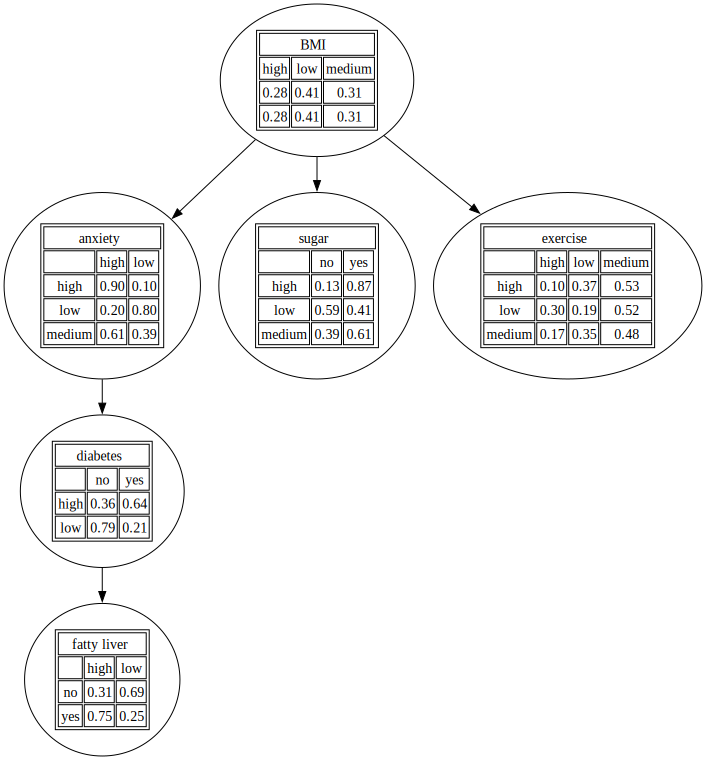

In [61]:
# Tree Search
tree = TreeSearch(train_data)
tree_model = tree.estimate()

draw_model(tree_model, "Tree Search Structure")
ts_model = calculate_cpts(tree_model, train_data)

3. Using the structure_score function from pgmpy.metrics calculate the BIC scores of the three models (found with the 3 search algorithms) over the validation data. Which model do you choose? Briefly comment on the score.

In [64]:
print("Model Nodes:", pc_model.nodes())
print("Validation Data Columns:", val_data.columns)

Model Nodes: ['anxiety', 'diabetes', 'exercise', 'BMI', 'fatty liver', 'sugar']
Validation Data Columns: Index(['exercise', 'BMI', 'sugar', 'fatty liver', 'anxiety', 'diabetes'], dtype='object')


In [65]:
from pgmpy.metrics import structure_score

In [66]:
print("PC Model expects:", pc_model.nodes())
print("HC Model expects:", hc_model.nodes())
print("Tree Model expects:", tree_model.nodes())

print("Available columns:", val_data.columns.tolist())

PC Model expects: ['anxiety', 'diabetes', 'exercise', 'BMI', 'fatty liver', 'sugar']
HC Model expects: ['BMI', 'sugar', 'exercise', 'fatty liver', 'anxiety', 'diabetes']
Tree Model expects: ['BMI', 'anxiety', 'sugar', 'exercise', 'diabetes', 'fatty liver']
Available columns: ['exercise', 'BMI', 'sugar', 'fatty liver', 'anxiety', 'diabetes']


In [67]:
val_data_reordered_pc = val_data[list(pc_model.nodes())]
val_data_reordered_hc = val_data[list(hc_model.nodes())]
val_data_reordered_tree = val_data[list(tree_model.nodes())]

pc_score = structure_score(pc_model, val_data_reordered_pc, scoring_method='bic')
hc_score = structure_score(hc_model, val_data_reordered_hc, scoring_method='bic')
tree_score = structure_score(tree_model, val_data_reordered_tree, scoring_method='bic')

print("BIC Scores:")
print(f"PC Model: {pc_score}")
print(f"Hill Climbing Model: {hc_score}") 
print(f"Tree Model: {tree_score}")

BIC Scores:
PC Model: -8670.507612238003
Hill Climbing Model: -8688.97579673113
Tree Model: -8791.333816760178


The best BIC is the one of the Hill Climbing Model with -8,688.33, since we want it to be the one with the biggest score and in this case the one with the largest BIC is the most negative one.

4. Using the best model you chose in Q3, answer the following questions:
(a) How much does increasing exercise levels, from “low” to “high” reduce the likelihood of experiencing anxiety?


In [73]:
pc = PC(train_data)
pc_dag = pc.estimate()

pc_model = BayesianNetwork(pc_dag.edges())
pc_model.fit(train_data)

pc_inference = VariableElimination(pc_model)

  0%|          | 0/5 [00:00<?, ?it/s]

In [76]:
low_result = pc_inference.query(['anxiety'], evidence= {'exercise':'low'})
high_result = pc_inference.query(['anxiety'], evidence= {'exercise':'high'})
medium_result = pc_inference.query(['anxiety'], evidence= {'exercise':'medium'})
percent = ((high_result.values[0] - low_result.values[0]) / low_result.values[0]) * 100

print(f"Probability of anxiety(high) with evidence of exercise=low: {low_result.values[0]*100:.2f}%")
print(low_result)
print(' ')
print(f"Probability of anxiety(high) with evidence of exercise=medium: {medium_result.values[0]*100:.2f}%")
print(medium_result)
print(' ')
print(f"Probability of anxiety(high) with evidence of exercise=high: {high_result.values[0]*100:.2f}%")
print(high_result)
print(' ')
print(f"Percentage change in probability of anxiety(high) when increasing from low to high exercise levels: {percent:.2f}%")

Probability of anxiety(high) with evidence of exercise=low: 59.97%
+---------------+----------------+
| anxiety       |   phi(anxiety) |
+===============+================+
| anxiety(high) |         0.5997 |
+---------------+----------------+
| anxiety(low)  |         0.4003 |
+---------------+----------------+
 
Probability of anxiety(high) with evidence of exercise=medium: 52.17%
+---------------+----------------+
| anxiety       |   phi(anxiety) |
+===============+================+
| anxiety(high) |         0.5217 |
+---------------+----------------+
| anxiety(low)  |         0.4783 |
+---------------+----------------+
 
Probability of anxiety(high) with evidence of exercise=high: 40.12%
+---------------+----------------+
| anxiety       |   phi(anxiety) |
+===============+================+
| anxiety(high) |         0.4012 |
+---------------+----------------+
| anxiety(low)  |         0.5988 |
+---------------+----------------+
 
Percentage change in probability of anxiety(high) when

Increasing exercise levels is associated with a decrease in anxiety. Moving from low to medium exercise reduces the likelihood of high anxiety by 6.8%, while increasing from medium to high exercise reduces it by 12.05%. Overall, going from low to high exercise results in a 33.09% total reduction in the likelihood of experiencing high anxiety.

(b) How does increasing sugar intake affect the likelihood of experiencing anxiety and diabetes? (provide a quantitative answer).

In [77]:
low_result = pc_inference.query(['anxiety'], evidence= {'sugar':'no'})
high_result = pc_inference.query(['anxiety'], evidence= {'sugar':'yes'})
percent = ((high_result.values[0] - low_result.values[0]) / low_result.values[0]) * 100

print(f"Probability of anxiety with evidence of sugar=no: {low_result.values[0]*100:.2f}%")
print(low_result)
print(' ')
print(f"Probability of anxiety with evidence of sugar=yes: {high_result.values[0]*100:.2f}%")
print(high_result)
print(' ')
print(f"Percentage change in anxiety(high) probability when increasing sugar intake: {percent:.2f}%")

Probability of anxiety with evidence of sugar=no: 38.64%
+---------------+----------------+
| anxiety       |   phi(anxiety) |
+===============+================+
| anxiety(high) |         0.3864 |
+---------------+----------------+
| anxiety(low)  |         0.6136 |
+---------------+----------------+
 
Probability of anxiety with evidence of sugar=yes: 60.87%
+---------------+----------------+
| anxiety       |   phi(anxiety) |
+===============+================+
| anxiety(high) |         0.6087 |
+---------------+----------------+
| anxiety(low)  |         0.3913 |
+---------------+----------------+
 
Percentage change in anxiety(high) probability when increasing sugar intake: 57.55%


Increasing sugar intake is associated with a 58.14% increase in the likelihood of experiencing high anxiety.

Increasing sugar intake above 7g increases the probabilty of high anxiety by 57%.

In [78]:
low_result = pc_inference.query(['diabetes'], evidence= {'sugar':'no'})
high_result = pc_inference.query(['diabetes'], evidence= {'sugar':'yes'})

percent = ((high_result.values[1] - low_result.values[1]) / low_result.values[1]) * 100

print('Sugar Intake Impact on Diabetes')
print(f"Probability of diabetes with evidence of sugar=no: {low_result.values[1]*100:.2f}%")
print(low_result)
print(' ')
print(f"Probability of diabetes with evidence of sugar=yes: {high_result.values[1]*100:.2f}%")
print(high_result)
print(' ')
print(f"Percentage change in probability of diabetes when increasing sugar intake: {percent:.2f}%")

Sugar Intake Impact on Diabetes
Probability of diabetes with evidence of sugar=no: 35.00%
+---------------+-----------------+
| diabetes      |   phi(diabetes) |
+===============+=================+
| diabetes(no)  |          0.6500 |
+---------------+-----------------+
| diabetes(yes) |          0.3500 |
+---------------+-----------------+
 
Probability of diabetes with evidence of sugar=yes: 48.43%
+---------------+-----------------+
| diabetes      |   phi(diabetes) |
+===============+=================+
| diabetes(no)  |          0.5157 |
+---------------+-----------------+
| diabetes(yes) |          0.4843 |
+---------------+-----------------+
 
Percentage change in probability of diabetes when increasing sugar intake: 38.36%


Increasing sugar intake is associated with a 38.63% increase in the likelihood of developing diabetes.

*Likelihood of Joint Probability*

In [79]:
low_result = pc_inference.query(['anxiety', 'diabetes'], evidence={'sugar': 'no'})
high_result = pc_inference.query(['anxiety', 'diabetes'], evidence={'sugar': 'yes'})

percent = ((high_result.values[0, 1] - low_result.values[0, 1]) / low_result.values[0, 1]) * 100

print(f"Joint probability of anxiety(high) and diabetes(yes) with evidence of sugar=no: {low_result.values[0, 1]*100:.2f}%")
print(low_result)
print(' ')
print(f"Joint probability of anxiety(high) and diabetes(yes) with evidence of sugar=yes: {high_result.values[0, 1]*100:.2f}%")
print(high_result)
print(' ')
print(f"Percentage change in joint probability of having anxiety and diabetes from low to high sugar intake: {percent:.2f}%")

Joint probability of anxiety(high) and diabetes(yes) with evidence of sugar=no: 22.92%
+---------------+---------------+-------------------------+
| anxiety       | diabetes      |   phi(anxiety,diabetes) |
+===============+===============+=========================+
| anxiety(high) | diabetes(no)  |                  0.1571 |
+---------------+---------------+-------------------------+
| anxiety(high) | diabetes(yes) |                  0.2292 |
+---------------+---------------+-------------------------+
| anxiety(low)  | diabetes(no)  |                  0.4928 |
+---------------+---------------+-------------------------+
| anxiety(low)  | diabetes(yes) |                  0.1208 |
+---------------+---------------+-------------------------+
 
Joint probability of anxiety(high) and diabetes(yes) with evidence of sugar=yes: 39.90%
+---------------+---------------+-------------------------+
| anxiety       | diabetes      |   phi(anxiety,diabetes) |
+===============+===============+==========

 Increasing sugar intake is associated with a 74.10% increase in the likelihood of experiencing both high anxiety and diabetes simultaneously.